In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from pandas_datareader import wb
import statsmodels.api as sm 
from sklearn import datasets
import matplotlib.cbook as cbook
from IPython.display import display
from ipywidgets import interact
import ipywidgets as widgets
from pandas_datareader import wb
import seaborn as sns
from scipy.stats import linregress
from scipy import signal

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject_unfucked as dataproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read and clean data

We use an API to download World bank data for GDP and Gini-coefficient for different countries 1990-2017. The API is embedded in a function we callmy_wb_downloader.

We have already downloaded a separate dataset WGI_levels.csv as we were unable to get these data through the API.

We then merge the two datasets and transform them to a wide format, ie. of the form:

\TABLE
country   year   var1   var2 ...
A         1990      x      x
A         1991      x      x
...
A         2017      x      x
B         1990      x      x
...

In [7]:
# Get World Bank Data, all countries, 1990-2017
# - GDP
# - GINI

# List of variables to rename
wb_variables_with_new_names = {'SI.POV.GINI'   :'GINI',
                                'NY.GDP.PCAP.KD':'GDP',
                               'NY.GDP.PCAP.KD.ZG':'GDP_growth'}
# Download and clean data
wb1 = dataproject.my_wb_downloader('all', wb_variables_with_new_names, 1990, 2017)

# Print data
wb1.sample(5)

,country,year,GINI,GDP,GDP_growth
3767,Honduras,2002,55.7,1787.096899,1.063681
2143,British Virgin Islands,2002,NaN,NaN,NaN
574,IDA only,2003,NaN,758.102472,2.146246
4189,Kazakhstan,2000,NaN,4446.452533,10.130116
1261,Sub-Saharan Africa (excluding high income),2016,NaN,1652.640764,-1.289956


In [8]:
frame= dataproject.WGI_DataFrame("WB WGI Levels.csv")
frame.info()

0 Now rename Series Control of Corruption: Estimate = COC
1 Now rename Series Government Effectiveness: Estimate = GOV
2 Now rename Series Political Stability and Absence of Violence/Terrorism: Estimate = RSA
3 Now rename Series Regulatory Quality: Estimate = REQ
4 Now rename Series Rule of Law: Estimate = ROL
5 Now rename Series Voice and Accountability: Estimate = VOA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4922 entries, 0 to 4921
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  4922 non-null   object
 1   year     4922 non-null   int64 
 2   COC      4922 non-null   object
 3   GOV      4922 non-null   object
 4   REQ      4922 non-null   object
 5   ROL      4922 non-null   object
 6   RSA      4922 non-null   object
 7   VOA      4922 non-null   object
dtypes: int64(1), object(7)
memory usage: 307.8+ KB


In [9]:
final=dataproject.merge(wb1,frame)
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8191 entries, 0 to 8493
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     8191 non-null   object 
 1   year        8191 non-null   int32  
 2   GINI        1577 non-null   float64
 3   GDP         6624 non-null   float64
 4   GDP_growth  6641 non-null   float64
 5   COC         4619 non-null   float64
 6   GOV         4619 non-null   float64
 7   REQ         4619 non-null   float64
 8   ROL         4619 non-null   float64
 9   RSA         4619 non-null   float64
 10  VOA         4619 non-null   float64
dtypes: float64(9), int32(1), object(1)
memory usage: 735.9+ KB


# Descriptive statistics

In [11]:
# Group variables
allyearslist = list(range(2002,2017))
subyearlist  = [2002, 2007, 2012, 2017]

# List of all governance index variables
varlist_wgi = ['COC','GOV', 'RSA', 'REQ', 'ROL', 'VOA']

# List of all normalized governance index variables
varlist_wgi_norm = list(map(lambda x: x + '_norm', varlist_wgi))

# List of all variables
varlist_all = ['GDP', 'GINI'] + varlist_wgi

# Ensure all variables are perfectly normalized within year
final = dataproject.standardize_by_group(final, varlist_wgi, 'year')

# Simple Descriptive Statistics
simplestats_noyear = dataproject.calc_simplestats(final, varlist_all,      group_by_year=False)
simplestats        = dataproject.calc_simplestats(final, varlist_all,      group_by_year=True, groups_to_print=subyearlist)
simplestats_norm   = dataproject.calc_simplestats(final, varlist_wgi_norm, group_by_year=True, groups_to_print=subyearlist)

# Print stats
print('N, Mean, Std. across all years')
display(simplestats_noyear)

# Print stats by year
for var in varlist_all:
    print(var)
    display(simplestats[var])

# Print normalized wgi stats by year
for var in varlist_wgi_norm:
    print(var)
    display(simplestats_norm[var])

N, Mean, Std. across all years


,GDP,GINI,COC,GOV,RSA,REQ,ROL,VOA
count,6624.000000,1577.000000,4619.000000,4619.000000,4619.000000,4619.000000,4619.000000,4619.000000
mean,11852.048243,38.268992,-0.010643,-0.008899,-0.028062,-0.007569,-0.022902,-0.024310
std,17624.031024,9.040012,0.999923,0.998163,0.996367,0.998880,1.003089,0.997422


GDP


,count,mean,std
year,,,
2002,229,11242.877165,16976.466283
2007,246,13321.879873,19591.879133
2012,251,13596.819953,18853.108183
2017,248,13899.362356,18753.806262


GINI


,count,mean,std
year,,,
2002,54,41.307407,9.622965
2007,70,36.481429,8.103055
2012,85,36.310588,7.231891
2017,76,35.507895,6.994164


COC


,count,mean,std
year,,,
2002,186,-0.003314,1.010104
2007,205,-0.001488,1.000923
2012,210,0.003180,1.004181
2017,202,-0.039934,0.990901


GOV


,count,mean,std
year,,,
2002,186,-6.809671e-10,1.000000
2007,205,-2.534813e-03,1.003514
2012,210,9.515541e-03,0.999963
2017,202,-3.019827e-02,1.001690


RSA


,count,mean,std
year,,,
2002,186,-0.007805,1.005875
2007,205,-0.015685,0.998778
2012,210,-0.009879,0.999587
2017,202,-0.045241,0.995372


REQ


,count,mean,std
year,,,
2002,186,-2.803982e-09,1.000000
2007,205,-8.804664e-04,1.004836
2012,210,9.753901e-03,0.999653
2017,202,-2.368051e-02,1.004438


ROL


,count,mean,std
year,,,
2002,186,-0.060509,1.016282
2007,205,-0.011584,1.004498
2012,210,-0.000605,1.001863
2017,202,-0.029992,1.000092


VOA


,count,mean,std
year,,,
2002,186,-0.068941,1.002485
2007,205,-0.014475,1.000576
2012,210,-0.004995,1.003467
2017,202,-0.010031,0.999662


COC_norm


,count,mean,std
year,,,
2002,186,-1.850372e-17,1.0
2007,205,-1.299773e-17,1.0
2012,210,-2.431917e-17,1.0
2017,202,9.893076e-18,1.0


GOV_norm


,count,mean,std
year,,,
2002,186,-1.134099e-17,1.0
2007,205,-1.733031e-17,1.0
2012,210,0.000000e+00,1.0
2017,202,-1.868692e-17,1.0


RSA_norm


,count,mean,std
year,,,
2002,186,-1.193788e-18,1.0
2007,205,1.353931e-17,1.0
2012,210,1.057355e-18,1.0
2017,202,-1.099231e-18,1.0


REQ_norm


,count,mean,std
year,,,
2002,186,-1.193788e-18,1.0
2007,205,2.653704e-17,1.0
2012,210,-7.401487e-18,1.0
2017,202,-9.893076e-18,1.0


ROL_norm


,count,mean,std
year,,,
2002,186,1.432546e-17,1.0
2007,205,-5.957294e-18,1.0
2012,210,-2.749124e-17,1.0
2017,202,1.758769e-17,1.0


VOA_norm


,count,mean,std
year,,,
2002,186,2.626334e-17,1.0
2007,205,1.137302e-17,1.0
2012,210,1.850372e-17,1.0
2017,202,-2.748077e-17,1.0


### We find that

The orld Governance Indicators (WGI) variables in the World bank data set are practically already normalized. However we still normalize them by mean and standard deviation to ensure valid enterpritation.

Mean GDP per capita (cross countries) is increansing over time.

Mean GINI (cross countries) is decreasing over time

The World Governance Indicators are stable over time as they are normalized with-in year. So we can only use them to analyse the rank of the different countries, not for analyzing trends over time.


# Analysis

interactive(children=(Dropdown(description='year', options=(1996.0, 1998.0, 2000.0, 2002.0, 2003.0, 2004.0, 20…

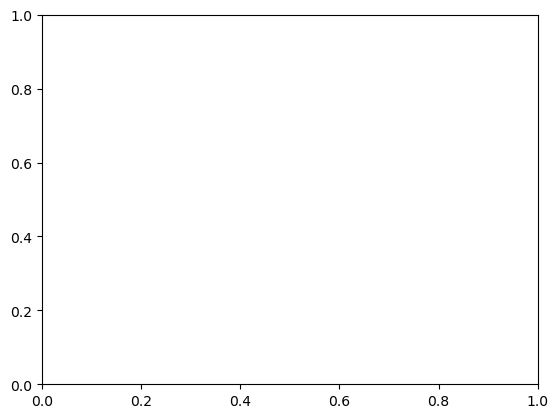

In [17]:
scatter_plot = dataproject_KRE.ScatterPlot(finaldata)
scatter_plot.interact_plot()

interactive(children=(Dropdown(description='year', options=(1996.0, 1998.0, 2000.0, 2002.0, 2003.0, 2004.0, 20…

<function __main__.plot_scatter(year)>

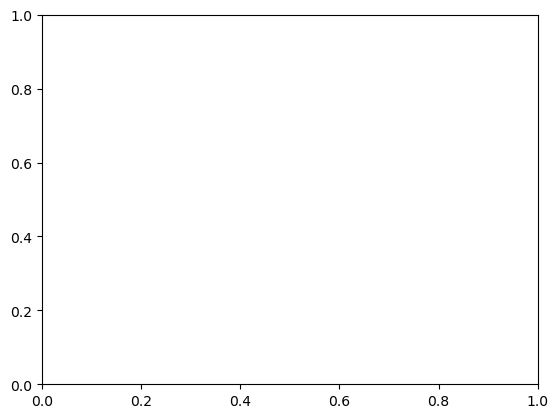

In [22]:
# We create a new DataFrame called final_data by dropping all rows with missing values in 'GINI', 'GDP', and 'COC' columns using the dropna() method.
final_data = final.dropna(subset=['GINI', 'GDP', 'COC'], how='any')

# We create a new variable quality and sets it equal to the 'COC' column of the final_data DataFrame
quality = final_data.COC

# We define variables cmin and cmax, which respectively store the minimum and maximum values of the 'COC' column in the final_data DataFrame. These values are used to set the range of the colorbar in the plot.
cmin = final_data.COC.min()
cmax = final_data.COC.max()

# We define a function called plot_scatter that creates a scatter plot of 'GINI' vs 'GDP' for a given year. The plot is colored based on the 'COC' variable, which is represented by a colorbar. The minimum and maximum values of the 'COC' column are used to set the range of the colorbar.
def plot_scatter(year):
    fig, ax = plt.subplots()
    scatter = ax.scatter(final_data[final_data['year'] == year]['GINI'], final_data[final_data['year'] == year]['GDP'],
                         c=final_data[final_data['year'] == year]['COC'], alpha=0.5, vmin=cmin, vmax=cmax)
    ax.set_xlabel(r'$GINI$', fontsize=15)
    ax.set_ylabel(r'$GDP$', fontsize=15)
    ax.set_title('GINI and GDP (Year: {})'.format(year))
    ax.set_xlim(final_data['GINI'].min(), final_data['GINI'].max())  # Set x-axis limits
    ax.set_ylim(final_data['GDP'].min(), final_data['GDP'].max())  # Set y-axis limits
    ax.grid(True)
    fig.tight_layout()
    # Add color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('COC', fontsize=12)  # Set color bar label
    plt.show()

# Create a list of unique years in ascending order
years = sorted(final_data['year'].unique())  

# We create an interactive plot of the plot_scatter function, with the year variable being controlled by a slider. The slider allows to choose a specific year to plot the scatter plot for.
interact(plot_scatter, year=years)

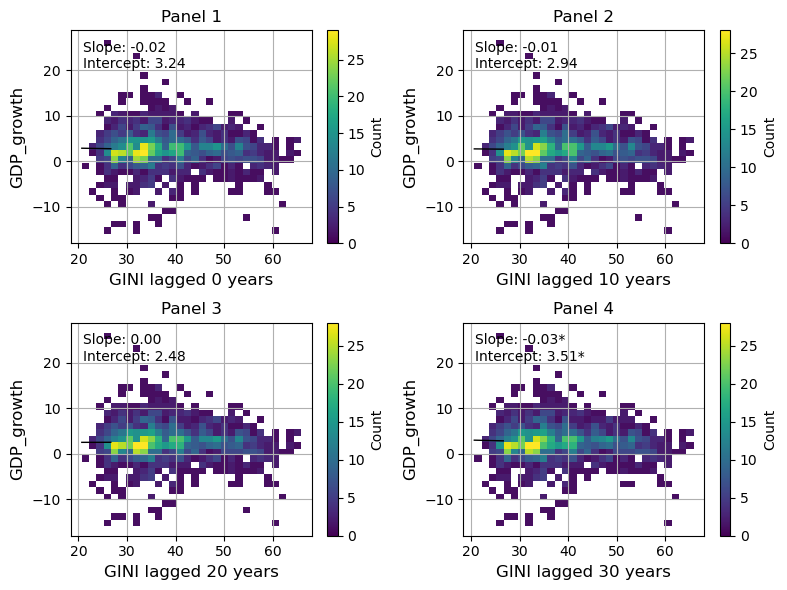

In [131]:
dataproject.corr(final,'GINI','GDP_growth')

In [132]:
# a list named list is defined, which contains the names of the six independent variables.
x_list1 = ['COC_norm', 'GOV_norm', 'REQ_norm', 'ROL_norm', 'RSA_norm', 'VOA_norm']
reg_results1 = dataproject.regression(final,'GDP',x_list1)

                            OLS Regression Results                            
Dep. Variable:                    GDP   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     166.9
Date:                Sun, 16 Apr 2023   Prob (F-statistic):          1.13e-185
Time:                        14:12:19   Log-Likelihood:                -36694.
No. Observations:                3298   AIC:                         7.340e+04
Df Residuals:                    3291   BIC:                         7.344e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.285e+04    287.030     44.752      0.0

In [133]:
# a list named list is defined, which contains the names of the six independent variables.
x_list2 = ['COC_norm', 'GOV_norm', 'REQ_norm', 'ROL_norm', 'RSA_norm', 'VOA_norm']
reg_results1 = dataproject.regression(final,'GINI',x_list2)

                            OLS Regression Results                            
Dep. Variable:                   GINI   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     39.34
Date:                Sun, 16 Apr 2023   Prob (F-statistic):           7.56e-43
Time:                        14:12:23   Log-Likelihood:                -3340.5
No. Observations:                 958   AIC:                             6695.
Df Residuals:                     951   BIC:                             6729.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         38.7197      0.281    137.948      0.0

In [12]:
# Sort dataset to contain years 2000-2020
years = range(2000, 2021)
final1 = final.loc[final['year'].isin(years)]
final1 = final1.dropna(subset=['GDP'], how='any')

# Detrend GDP
y = final1.loc[:, 'GDP']
y_detrended = signal.detrend(y)

# Calculate std. of GDP for each country
final1['std'] = final1.groupby('country')['GDP'].transform('std')

# Select only one year (=2017)
final2 = final1.loc[final['year'] == 2000]

# Regress std. on lagged governance
X = final2.loc[:, ['COC']]  # COC should be changed to governance indicator
X = sm.add_constant(X)

y = final2.loc[:, 'std']

model = sm.OLS(y, X, missing='drop')
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    std   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     37.50
Date:                Sat, 15 Apr 2023   Prob (F-statistic):           6.14e-09
Time:                        10:23:57   Log-Likelihood:                -1553.4
No. Observations:                 172   AIC:                             3111.
Df Residuals:                     170   BIC:                             3117.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1425.8404    155.212      9.186      0.000    1119.450    1732.231
COC          941.5879    153.758      6.124      0.000     638.066    1245.110
==============================================================================
Omnibus:                      253.216   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23129.848
Skew:                           6.336   Prob(JB):                         0.00
Kurtosis:                      58.379   Cond. No.                         1.02
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Conclusion

ADD CONCISE CONLUSION.